## Introduction

This is a brief exploratory analysis of the data provided by the  <a href='http://muop-mupdreports.missouri.edu/dclog.php'>MU Police Daily Crime Log</a>. The data was scraped using <a href='https://github.com/Daniel-Bassett/mu-crime-stats/blob/master/scrapers/mu_crime_scraper.ipynb'>mu_crime_scraper.ipynb</a>. It has already been cleaned and geocoded using <a href='https://github.com/Daniel-Bassett/mu-crime-stats/blob/master/wrangler/data_wrangler.ipynb'>data_wrangler.ipynb</a> and <a href='https://github.com/Daniel-Bassett/mu-crime-stats/blob/master/scrapers/crime_geocode_scraper.ipynb'>crime_geocode_scraper.ipynb</a> respectively. However, further wrangling is done in this notebook. The objective is to find useful insight into the crime trends in the MU campus area using descriptive analytics and machine learning. The focus will be on the times that crimes occurred, the location of crimes, and the types of crimes.

## Tale of Contents

1. [Import Libraries](#Import-Libraries)
2. [Data Wrangling](#Data-Wrangling)
    - [Location](#Location)
    - [Dates and Times](#Dates-and-Times)
3. [Descriptive Analytics](#Descriptive-Analytics)
    - [Criminal Offenses](#Criminal-Offenses)
    - [Criminal Activity Locations](#Criminal-Activity-Locations)
    - [Crime by Time](#Crime-by-Time)
4. [Predictive Analytics](#Predictive-Analytics)
    - [Load Libraries](#Load-Libraries)
    - [Prepare Data](#Prepare-Data)
    - [Random Forest](#Random-Forest)
        - [Predict Location of a Crime](#Predict-Location-of-a-Crime)
        - [Predict the Type of Crime](#Predict-the-Type-of-Crime)
        - [Predict Hour of the Crime](#Predict-Hour-of-the-Crime)
    - [Tensorflow](#Tensorflow)
        - [Predict Location of a Crime](#tf-predict-location)
        - [Predict the Type of Crime](#tf-predict-type)
        - [Predict Hour of the Crime](#tf-predict-hour)
    - [Results](#Results)
5. [Conclusion](#Conclusion)

## Import Libraries

In [1]:
# data wrangling and exploration
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.io as pio
import kaleido
sns.set()

## Data Wrangling

In [2]:
# import data
crime_df = pd.read_csv('../data/crime-log-geocode-raw.csv')

In [3]:
# check for null values
crime_df.isnull().sum()

case_number              0
time_reported            0
time_started             0
time_ended               0
location_of_occurence    0
domestic_relationship    0
incident_type            0
criminal_offense         0
disposition              0
latitude                 0
longitude                0
dtype: int64

In [4]:
# correct misspelling from original raw data
crime_df = crime_df.rename(columns={'location_of_occurence': 'location_of_occurrence'})

In [5]:
# check for duplicate values
crime_df.duplicated().sum()

5672

In [6]:
# drop duplicates
crime_df = crime_df.drop_duplicates()

# drop "DRAWN IN ERROR" values
crime_df = crime_df.drop(crime_df[crime_df.incident_type == "DRAWN IN ERROR"].index)

# drop "OFFICE INFORMATION" incidents
crime_df = crime_df.drop(crime_df[crime_df.incident_type == "OFFICE INFORMATION (MUPD)"].index)

# data before October 2019 is severely lacking, so drop
crime_df = crime_df.query('time_started > "2019-09-30"')

### Location

In [7]:
# strip whitespace from locations
crime_df.location_of_occurrence = crime_df.location_of_occurrence.str.strip()

# convert "road", "drive", etc to "RD", "DR", etc. due to inconsistency in entry
crime_df.location_of_occurrence = crime_df.location_of_occurrence.str.replace("DRIVE, ", 'DR, ', regex=True)
crime_df.location_of_occurrence = crime_df.location_of_occurrence.str.replace("ROAD, ", 'RD, ', regex=True)
crime_df.location_of_occurrence = crime_df.location_of_occurrence.str.replace("STREET, ", 'ST, ', regex=True)
crime_df.location_of_occurrence = crime_df.location_of_occurrence.str.replace("AVENUE, ", 'AVE, ', regex=True)


# Some of the zip codes were entered incorrectly, so separate them from the address into their own column
crime_df['zip_code'] = crime_df.location_of_occurrence.str.extract(r'\b(\d{5})')

# delete zip codes from location so that we get a more accurate count of locations
crime_df.location_of_occurrence = crime_df.location_of_occurrence.str.replace(r', \b(\d{5})', '', regex=True)

### Dates and Times

In [8]:
# check data types for each columns, we can see the timestamp columns are object types instead of datetime
crime_df.dtypes

case_number                 int64
time_reported              object
time_started               object
time_ended                 object
location_of_occurrence     object
domestic_relationship      object
incident_type              object
criminal_offense           object
disposition                object
latitude                  float64
longitude                 float64
zip_code                   object
dtype: object

In [9]:
# convert date columns to datetime
crime_df.time_reported = pd.to_datetime(crime_df.time_reported)
crime_df.time_started = pd.to_datetime(crime_df.time_started)
crime_df.time_ended = pd.to_datetime(crime_df.time_ended)

In [10]:
# extract into new columns the year, month, day, hour, and day of week using time_started column. time_started is when the crime occurred
crime_df['year'] = crime_df.time_started.dt.year
crime_df['month'] = crime_df.time_started.dt.month
crime_df['day'] = crime_df.time_started.dt.day
crime_df['hour'] = crime_df.time_started.dt.hour
crime_df['day_of_week'] = crime_df.time_started.dt.day_name()

In [11]:
# reset index 
crime_df = crime_df.reset_index(drop=True)

## Descriptive Analytics

### Criminal Offenses

We can see from the first 20 rows of data under the "incident_type" column that there are several larcenies and assaults each with their own subcategories. Let's check the value counts. It might be better to lump all assaults into one category instead of having multiple subcategories. For example, instead of "ASSAULT - SIMPLE", change it to just "ASSAULT".

In [12]:
crime_df.head(20)

,case_number,time_reported,time_started,time_ended,location_of_occurrence,domestic_relationship,incident_type,criminal_offense,disposition,latitude,longitude,zip_code,year,month,day,hour,day_of_week
0,202300548,2023-04-24 16:56:00,2023-04-24 16:56:00,2023-04-24 16:56:00,"907 HITT ST, COLUMBIA MO",NO,PROPERTY DAMAGE,PROPERTY DAMAGE,ACTIVE,38.939613,-9.232680e+01,65201,2023,4,24,16,Monday
1,202300545,2023-04-23 18:26:00,2023-04-23 18:26:00,2023-04-23 18:26:00,"904 ELM ST, COLUMBIA MO",NO,HARASSMENT,HARASSMENT,ACTIVE,38.948217,-9.232689e+01,65211,2023,4,23,18,Sunday
2,202300544,2023-04-23 10:08:08,2023-04-23 08:08:41,2023-04-23 10:08:08,"1 HOSPITAL DR, COLUMBIA MO",NO,ASSAULT-SIMPLE,ASSAULT-SIMPLE,CLEARED BY ARREST,38.938273,-9.232738e+01,65201,2023,4,23,8,Sunday
3,202300544,2023-04-23 10:08:08,2023-04-23 08:08:41,2023-04-23 10:08:08,"1 HOSPITAL DR, COLUMBIA MO",NO,OTHER OFFENSE - NOT REPORTABLE,ASSAULT-SIMPLE,CLEARED BY ARREST,38.938273,-9.232738e+01,65201,2023,4,23,8,Sunday
4,202300542,2023-04-22 23:55:00,2023-04-22 23:55:00,2023-04-22 23:55:00,"399 E STADIUM BLVD, COLUMBIA MO",NO,TRAFFIC OFFENSE,TRAFFIC OFFENSE,CLEARED BY ARREST,38.938349,-9.233316e+01,65203,2023,4,22,23,Saturday
5,202300542,2023-04-22 23:55:00,2023-04-22 23:55:00,2023-04-22 23:55:00,"399 E STADIUM BLVD, COLUMBIA MO",NO,WARRANT ARREST,TRAFFIC OFFENSE,CLEARED BY ARREST,38.938349,-9.233316e+01,65203,2023,4,22,23,Saturday
6,202300541,2023-04-22 21:18:00,2023-04-22 21:18:00,2023-04-22 21:18:00,"1 HOSPITAL DR, COLUMBIA MO",NO,ASSAULT-SIMPLE,ASSAULT-SIMPLE,CLEARED BY ARREST,38.938273,-9.232738e+01,65201,2023,4,22,21,Saturday
7,202300540,2023-04-22 10:23:00,2023-04-22 10:23:00,2023-04-22 10:23:00,"1 HOSPITAL DR, COLUMBIA MO",NO,LARCENY - SHOPLIFTING,LARCENY - SHOPLIFTING,EXCEPTIONALLY CLEARED,38.938273,-9.232738e+01,65201,2023,4,22,10,Saturday
8,202300539,2023-04-22 07:22:00,2023-04-22 07:22:00,2023-04-22 07:22:00,"115 MIZZOU NORTH, COLUMBIA MO",NO,LARCENY - THEFT FROM BUILDING,LARCENY - THEFT FROM BUILDING,ACTIVE,38.967138,-9.233914e+01,65201,2023,4,22,7,Saturday
9,202300538,2023-04-22 01:06:00,2023-04-22 01:06:00,2023-04-22 01:06:00,"949 CONLEY AVE, COLUMBIA MO",NO,TRAFFIC OFFENSE,TRAFFIC OFFENSE,CLEARED BY ARREST,0.168257,9.087286e+07,65201,2023,4,22,1,Saturday


In [13]:
# value count for criminal_offense
crime_df.criminal_offense.value_counts().head(10)

FORGERY                     1441
DRUG - NARCOTIC             1273
TRAFFIC OFFENSE              567
LIQUOR LAW                   538
DWI                          533
ASSAULT-SIMPLE               428
CRASH INVESTIGATION          425
LARCENY - OTHER              408
PROPERTY DAMAGE              392
SICK/MENTALLY ILL PERSON     267
Name: criminal_offense, dtype: int64

One would expect there to be more larceny offenses. What are the results if all subcategories of larceny are combined into one large category? Let's do the same for other criminal offenses as well. We can keep the original column for more specific detail incase it is needed and create a new column for the general category.

In [14]:
# check number of larceny incidents
crime_df.query('criminal_offense.str.contains("LARCENY")').shape

(848, 17)

As you can see, if we filter the dataframe for all offenses that are larceny, it returns 853 incidents. In the original value count, this would have made it a top 3 crime. Let's go ahead and put all incidents into their respective general categories and check the results.

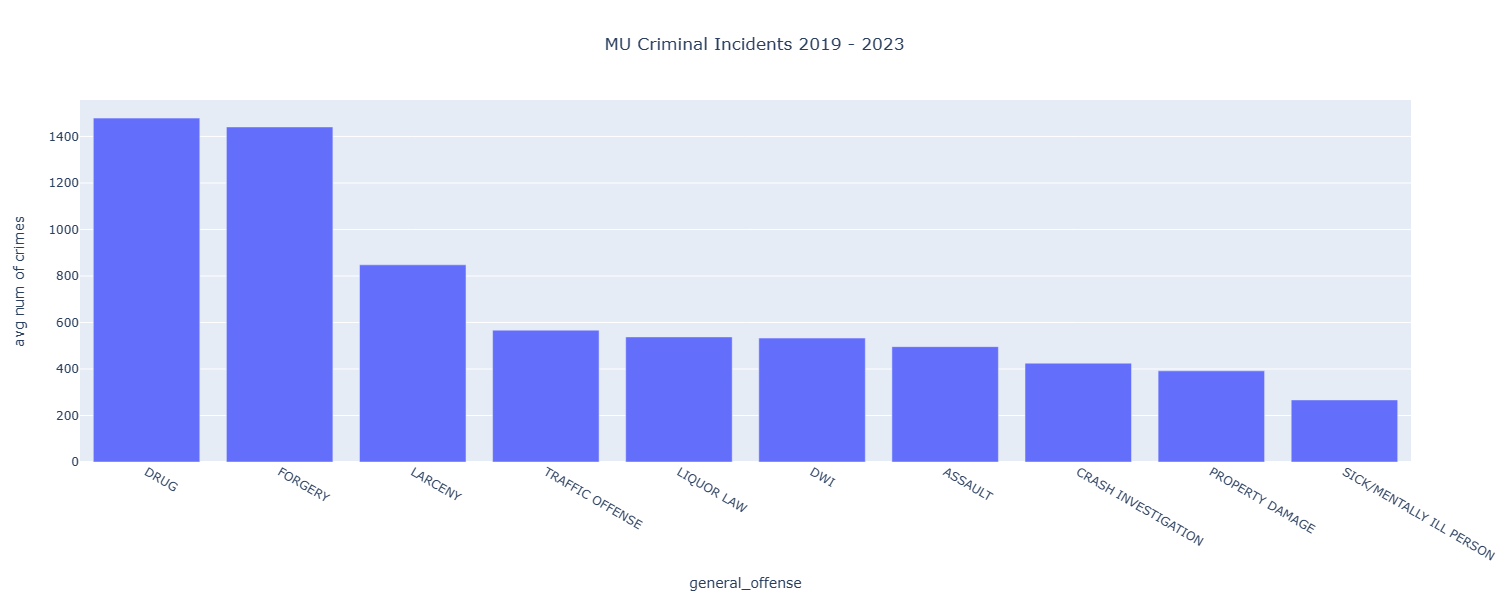

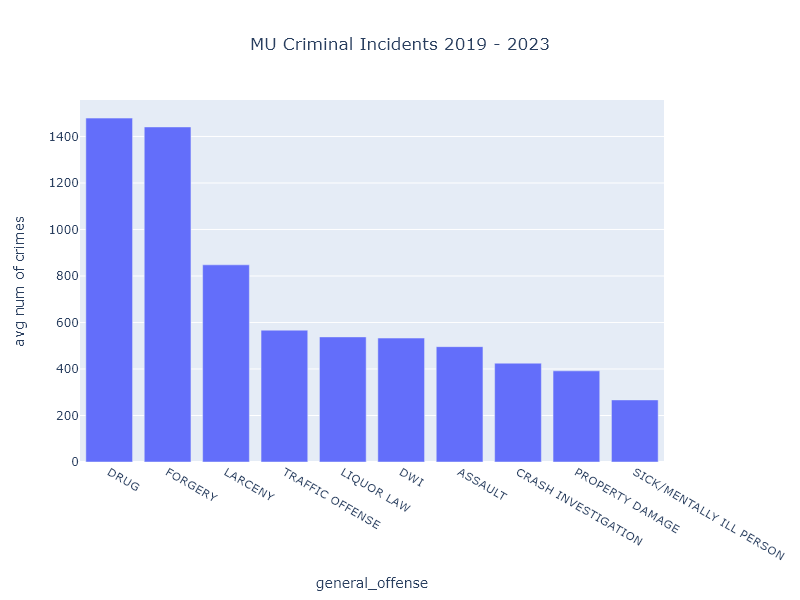

In [22]:
# create new column of a generalization of criminal offenses
crime_df['general_offense'] = crime_df.criminal_offense.str.replace(r'-.*', '', regex=True)

# plot top 10 criminal incidents
temp_df = crime_df.general_offense.value_counts().head(10)

temp_df = pd.DataFrame(temp_df)

temp_df = temp_df.reset_index().rename(columns={'general_offense': 'count','index': 'general_offense'})

temp_df['hover_info'] = 'Crime-Type: ' + temp_df.general_offense.astype(str) + '<br>' + 'Total Incidents: ' + temp_df['count'].astype(str)

crime_total = px.bar(temp_df, x='general_offense', y='count', title='MU Criminal Incidents 2019 - 2023', hover_data={'hover_info': True})

crime_total.update_layout(width=800, height=600, title_x=0.5, yaxis_title='avg num of crimes')

crime_total.update_traces(hovertemplate='%{customdata[0]}')

crime_total.show()
crime_total.show("png")

Drugs, forgery, and larcerny are by far the most common types of crimes in the MU area.

### Criminal Activity Locations

In [16]:
# value count for location
crime_df.location_of_occurrence.value_counts().head(10)

1 HOSPITAL DR, COLUMBIA MO           682
3 HOSPITAL DR, COLUMBIA MO           354
901 VIRGINIA AVE, COLUMBIA MO        192
309 HITT ST, COLUMBIA MO             168
1100 S PROVIDENCE RD, COLUMBIA MO    154
1199 E STADIUM BLVD, COLUMBIA MO      93
1099 S PROVIDENCE RD, COLUMBIA MO     89
800 VIRGINIA AVE, COLUMBIA MO         84
999 E STADIUM BLVD, COLUMBIA MO       83
904 S COLLEGE AVE, COLUMBIA MO        83
Name: location_of_occurrence, dtype: int64

A lot of incidents occuring near the hospital. Including "901 Virginia Ave", that is almost 20% of incidents happening near the hospital. It might be worth exploring the types of activities just in that area as compared to all the data.

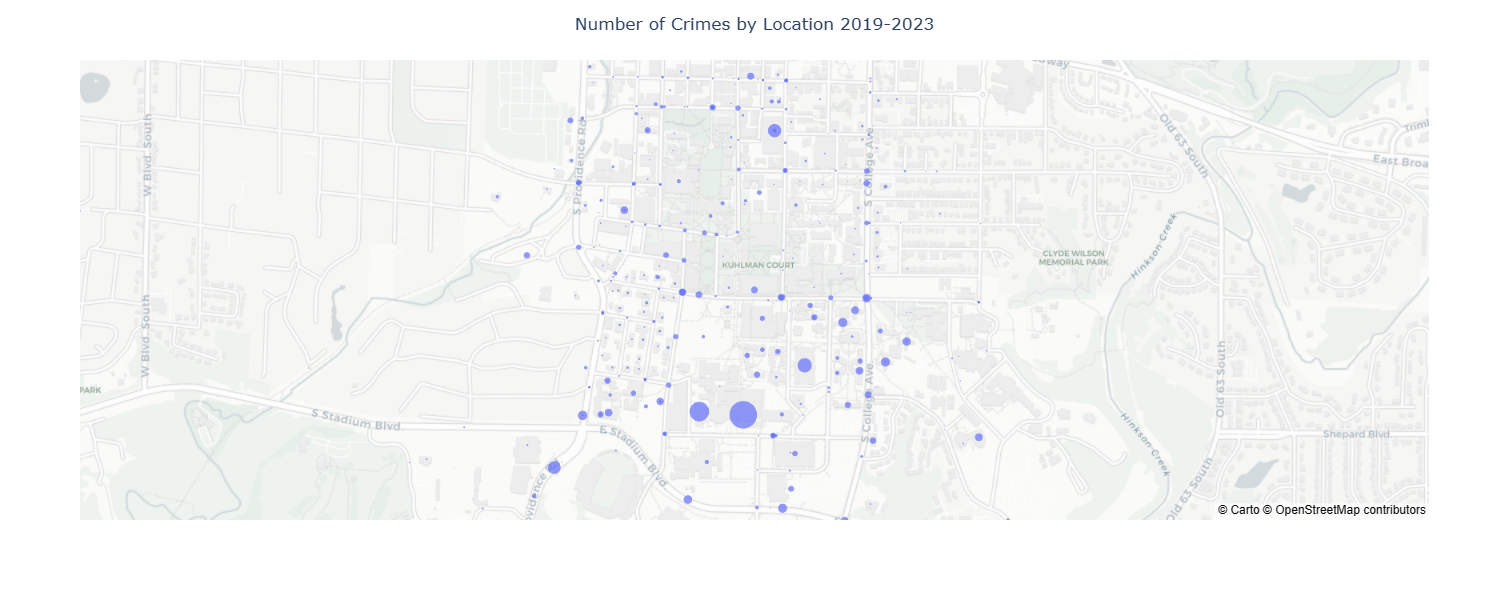

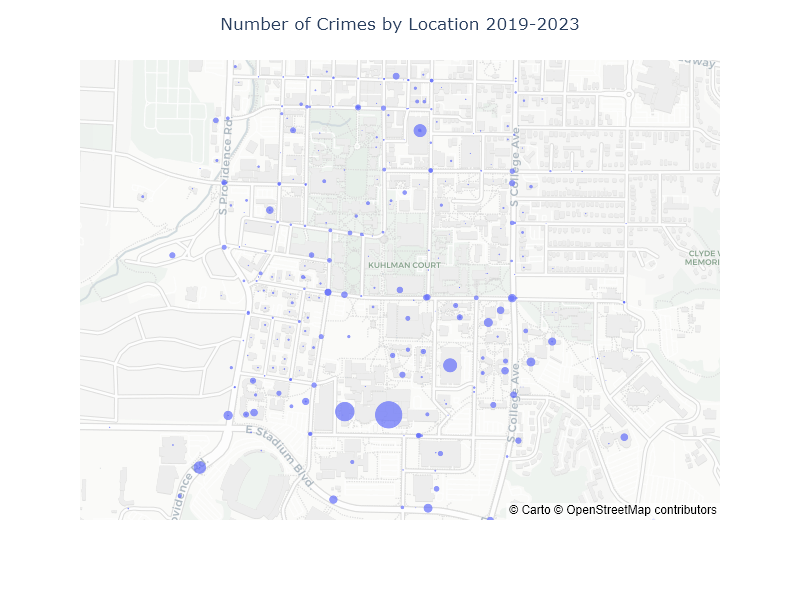

In [21]:
# create a dataframe that has count of number of crimes at each location
temp_df = crime_df.groupby(['latitude', 'longitude', 'location_of_occurrence'], as_index=False).size().sort_values(by='size', ascending=False)

# rename size column to n_crimes
temp_df = temp_df.rename(columns={'size': 'n_crimes'})

# for sake of clearer visualization, filter out locations that have less than 3 crimes
temp_df = temp_df.query('n_crimes > 2')

# new column in temp_df that contains all the info for hovering in map
temp_df['hover_info'] = 'Address: ' + temp_df.location_of_occurrence.astype(str) + '<br>' + 'Num of Crimes: ' + temp_df.n_crimes.astype(str)

# Create heatmap of criminal activity
activity_map = px.scatter_mapbox(
    temp_df,
    lat='latitude',
    lon='longitude',
    center=dict(lat=38.94244, lon=-92.3269),
    zoom=14,
    size='n_crimes',
    mapbox_style='carto-positron',
    hover_data={'latitude': False, 'longitude': False, 'n_crimes': False},
    hover_name='hover_info',
)

activity_map.update_layout(width=800, height=600, title='Number of Crimes by Location 2019-2023', title_x=0.5)
activity_map.show()
activity_map.show('png')

There is a lot of activity occurring near the university hospital and near parking garages. Surprisingly, there is a lot of crime happening at 901 Virginia Ave where the MU Police Department is headquartered. Another location of interest is the 309 Hitt Street parking garage with 168 crimes occuring.

### Crime by Time

#### Monthly Average

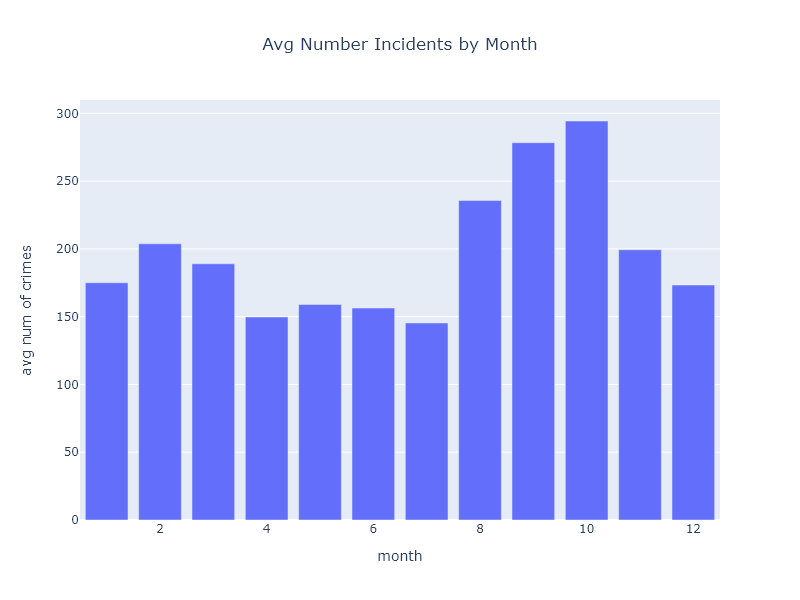

In [19]:
# Data for 2019 is lacking, so filter data from 2020 to present
temp_df = crime_df.groupby(['year', 'month'], as_index=False).size().query('year >= 2020')

temp_df = temp_df.groupby('month', as_index=False)['size'].mean()

temp_df['hover_info'] = 'Month: ' + temp_df.month.astype(str) + '<br>' + 'Avg Num Incidents: ' + temp_df['size'].round(1).astype(str)

monthly_avg = px.bar(temp_df, x='month', y='size', title='Avg Number Incidents by Month', hover_data={'hover_info': True})

monthly_avg.update_layout(width=800, height=600, title_x=0.5, yaxis_title='avg num of crimes', xaxis_title='month')

monthly_avg.update_traces(hovertemplate='%{customdata[0]}')

monthly_avg.show('png')

There is typically a large drop off in crime from May through July and December through January and a sizeable spike in August, coinciding with summer and winter break for students.

#### Day of the Week

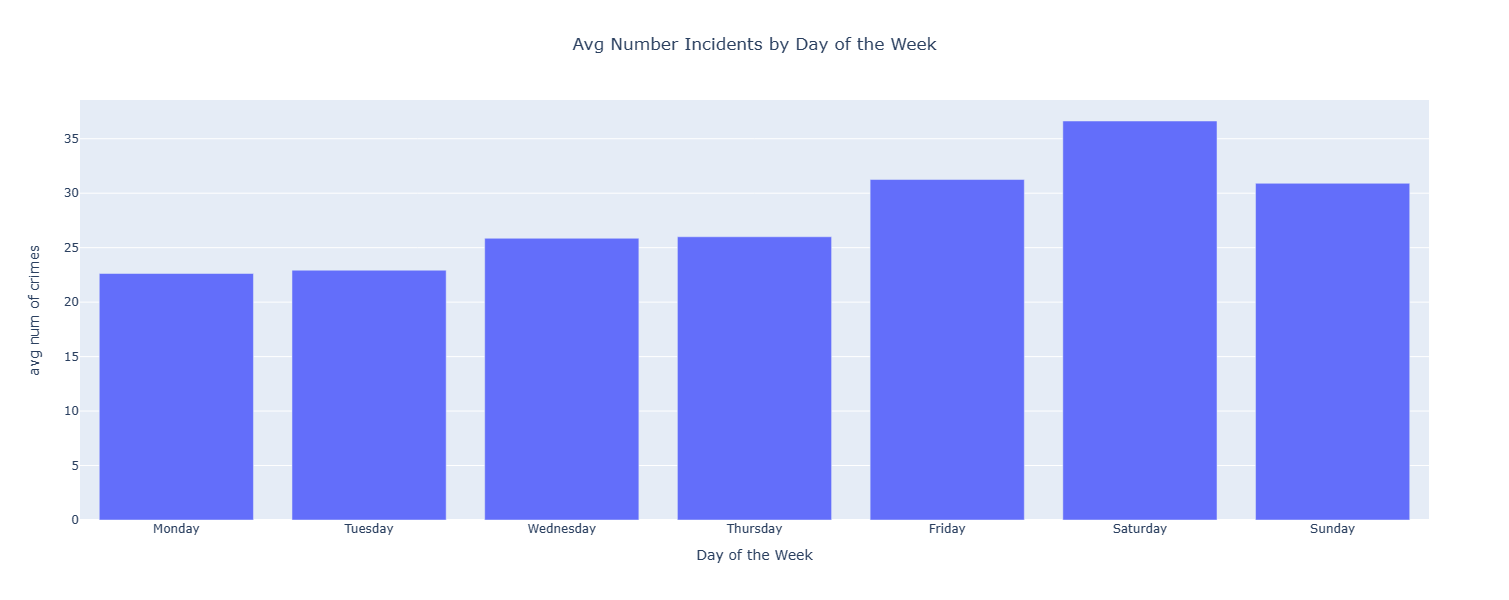

In [19]:
temp_df = crime_df.groupby(['year', 'month', 'day_of_week'], as_index=False).size()

temp_df = temp_df.groupby('day_of_week', as_index=False).mean()

temp_df['hover_info'] = 'Day of Week: ' + temp_df.day_of_week.astype(str) + '<br>' + 'Avg Num of Crimes: ' + temp_df['size'].round(1).astype(str)

day_avg = px.bar(temp_df, x='day_of_week', y='size', title='Avg Number Incidents by Day of the Week', hover_data={'hover_info': True, 'day_of_week': False, 'size': False})

day_avg.update_layout(width=800, height=600, 
                  title_x=0.5, 
                  yaxis_title='avg num of crimes', 
                  xaxis_title='Day of the Week',
                  xaxis={'categoryarray': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']}
                 )

day_avg.update_traces(hovertemplate='%{customdata[0]}')

day_avg.show()

As one could expect, a large uptick in incidents leading up to Saturday with a steep drop off on Monday

#### Time of Day

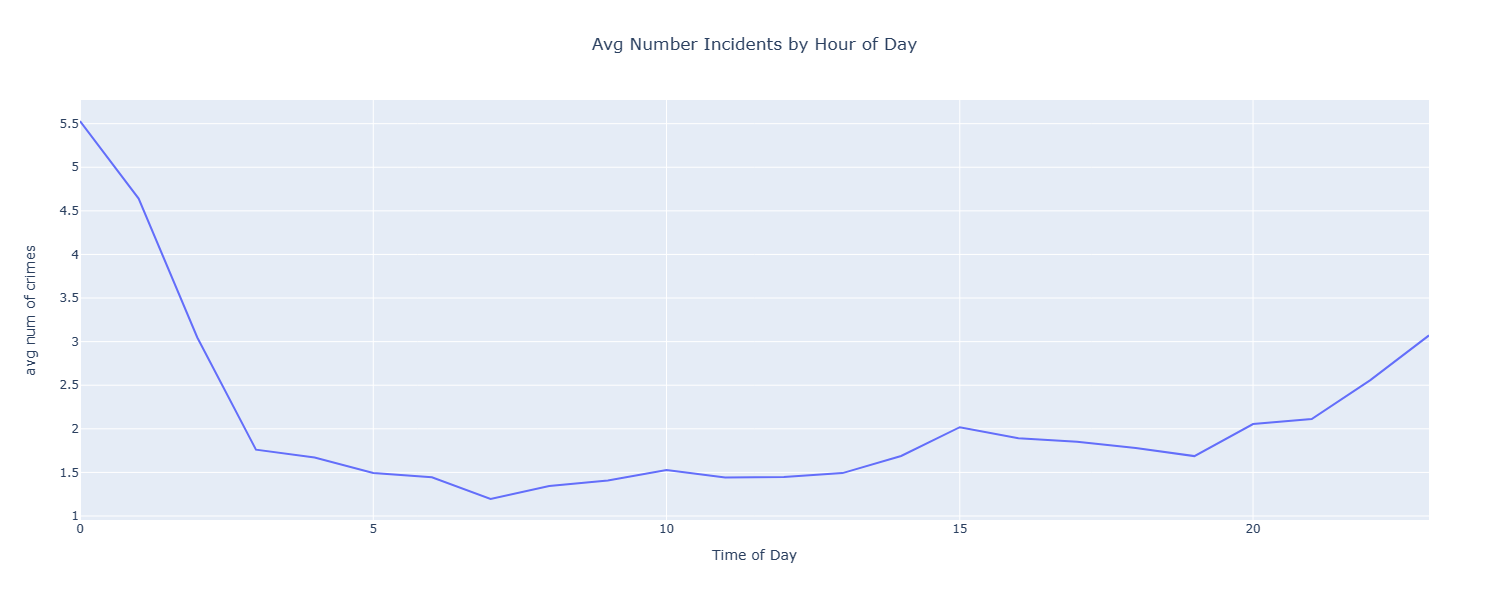

In [20]:
temp_df = crime_df.groupby(['year', 'month', 'day_of_week', 'hour'], as_index=False).size()

temp_df = temp_df.groupby('hour', as_index=False)['size'].mean()

temp_df['hover_info'] = 'Hour of Day: ' + temp_df.hour.astype(str) + '<br>' + 'Avg Num Incidents: ' + temp_df['size'].round(1).astype(str)

hour_avg = px.line(temp_df, x='hour', y='size', title='Avg Number Incidents by Hour of Day', hover_data={'hover_info': True})

hour_avg.update_layout(width=800, height=600, 
                  title_x=0.5, 
                  yaxis_title='avg num of crimes', 
                  xaxis_title='Time of Day',
                 )

hour_avg.update_traces(hovertemplate='%{customdata[0]}')

hour_avg.show()

The average number of incidents is least at 7 am. There is a sharp spike around midnight.

In [21]:
# create figure for display at conclusion
fig = sp.make_subplots(rows=2, cols=2, subplot_titles=('Crime-Type Total', 'Monthly Average', 'Day of Week Average', 'Hourly Average'))
fig.add_trace(crime_total['data'][0], row=1, col=1)
fig.add_trace(monthly_avg['data'][0], row=1, col=2)
fig.add_trace(day_avg['data'][0], row=2, col=1)
fig.add_trace(hour_avg['data'][0], row=2, col=2)
fig.update_xaxes(categoryorder='array', categoryarray=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], row=2, col=1)
fig.update_layout(width=1200, height=900)
;

''

## Predictive Analytics

Now that the data has been explored using descriptive analytics, let's try to gain insight from the data using machine learning algorithms. Scikit-learn's random forest classifier along with tensorflow will be used to try to predict three targets:
- Location of a Crime
- Type of Crime
- Hour of Day

In addition, hourly temperature and precipitation data from Oct. 2019 to April 2023 will be used as features to create more robust predictive models. The metrics will be the micro average of the precision, recall, and f1-score along with the accuracy of the model.

In [22]:
# import temperature precipitation data
precipitation_df = pd.read_csv('../data/precipitation.csv', delim_whitespace=True)
temperature_df = pd.read_csv('../data/temperature.csv', delim_whitespace=True)

# combine weather data into a weather dataframe
weather_df = pd.merge(precipitation_df, temperature_df)

# lowercase time columns to match crime_df's formatting
weather_df = weather_df.rename(columns={'MONTH': 'month', 'DAY': 'day', 'YEAR': 'year', 'HOUR': 'hour'})

# format hour column to match that of crime_df
weather_df.hour = weather_df.hour / 100
weather_df.hour = weather_df.hour.astype(int)
weather_df.hour = weather_df.hour.replace(24, 0)

crime_df = pd.merge(crime_df, weather_df, how='left', left_on=['year', 'month', 'day', 'hour'], right_on=['year', 'month', 'day', 'hour'])

In [23]:
# create an empty dataframe for the metrics 
rf_results = pd.DataFrame(index=range(4), columns=['location', 'crime_type', 'hour'])
rf_results.index = ['accuracy', 'precision', 'recall', 'f1-score']
rf_results

,location,crime_type,hour
accuracy,NaN,NaN,NaN
precision,NaN,NaN,NaN
recall,NaN,NaN,NaN
f1-score,NaN,NaN,NaN


In [24]:
# create dataframe for tensorflow metrics
tf_results = pd.DataFrame(index=range(4), columns=['location', 'crime_type', 'hour'])
tf_results.index = ['accuracy', 'precision', 'recall', 'f1-score']
tf_results

,location,crime_type,hour
accuracy,NaN,NaN,NaN
precision,NaN,NaN,NaN
recall,NaN,NaN,NaN
f1-score,NaN,NaN,NaN


### Load Libraries

In [25]:
# models
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# metrics
from sklearn.metrics import classification_report, f1_score, accuracy_score
from tensorflow import keras

# for converting categorical targets into integer labels
from sklearn.preprocessing import LabelEncoder

# splitting the data
from sklearn.model_selection import train_test_split

# scaling data
from sklearn.preprocessing import StandardScaler

### Prepare Data

The categorical features with counts less than 10 will be filtered out. This includes the 'location_of_occurrence' and 'general_offense' columns. This is to reduce the curse of dimensionality when applying one-hot encoding. You can see below that there are over one thousand categories in the location_of_occurrence. When one-hot encoding, this will add over 1000 new columns to the data.

In [26]:
print(f'Num of Categories in location_of_occurrence: {len(crime_df.location_of_occurrence.unique())}')
print(f'Num of Categories in general_offense: {len(crime_df.general_offense.unique())}')

Num of Categories in location_of_occurrence: 1069
Num of Categories in general_offense: 70


In [27]:
# make copy of dataframe
data = crime_df.copy()

# get the value counts for each location and general offense
temp_location_series = data.location_of_occurrence.value_counts()
temp_offense_series = data.general_offense.value_counts()

# create lists of locations and offenses with counts >= 10
location_list = temp_location_series[temp_location_series >= 10].index
offense_list = temp_offense_series[temp_offense_series >= 10].index

# use lists to filter the dataframe
data = data.query('location_of_occurrence.isin(@location_list) and general_offense.isin(@offense_list)')

print(f'Num of Categories in location_of_occurrence: {len(data.location_of_occurrence.unique())}')
print(f'Num of Categories in general_offense: {len(data.general_offense.unique())}')

Num of Categories in location_of_occurrence: 170
Num of Categories in general_offense: 34


By filtering the data, the number of locations has been reduced significantly. 

### Random Forest

In [28]:
# gets the metrics and inputs them into the results dataframe
def get_metrics(rf_results, metrics_df, prediction):
    for metric in ['precision', 'recall', 'f1-score']:
        rf_results.loc[metric, prediction] = metrics_df.loc['micro avg'][metric]
    return rf_results

In [29]:
# combines one hot encoded columns into one column for more concise view of importance
def sum_encoded_columns(encoded_columns, feature_names, importance_df):
    for column in encoded_columns:
        temp_sum = importance_df.query(f'feature.str.contains("{column}")').sum().values[1]
        temp_sum_df = pd.DataFrame({'feature': column, 'importance': temp_sum}, index=[len(importance_df)])
        importance_df = pd.concat([importance_df, temp_sum_df], ignore_index=True)
        importance_df = importance_df.query(f'~feature.str.contains("{column}_")')
    return importance_df.reset_index(drop=True).sort_values(by='importance', ascending=False)

#### Predict Location of a Crime

In [30]:
# set the features
X = data[['month', 'day', 'hour', 'day_of_week', 'general_offense', 'PRECIP', 'TEMP']].copy()

# keep record of columns for feature importance dataframe
original_columns = X.columns.tolist()

# one hot encoding
X = pd.get_dummies(X)

# create set of columns that were encoded, this is used for creating feature importance dataframe
encoded_columns = set(original_columns) - set(X.columns)

# set target, convert categorical target into integer label
y = data['location_of_occurrence']
y = pd.get_dummies(y)

# split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# create model and fit
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
# make predictions
predictions = model.predict(x_test)

In [33]:
# get classification report
metrics_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)

# convert to dataframe
metrics_df = pd.DataFrame(metrics_dict).transpose()

# add locations as index values
index_dict = {str(i): y.columns[i] for i in range(len(y.columns))}
metrics_df = metrics_df.rename(index=index_dict)

# round for readability
metrics_df = metrics_df.round(2)

metrics_df

,precision,recall,f1-score,support
"0 9TH ST, COLUMBIA MO",1.00,1.00,1.00,4.0
"0 E STADIUM BLVD, COLUMBIA MO",0.33,0.33,0.33,3.0
"0 HOSPITAL DR, COLUMBIA MO",0.50,0.50,0.50,2.0
"0 KENTUCKY BLVD, COLUMBIA MO",1.00,0.00,0.00,1.0
"0 S PROVIDENCE RD, COLUMBIA MO",1.00,0.75,0.86,4.0
...,...,...,...,...
"999 S COLLEGE AVE, COLUMBIA MO",1.00,0.55,0.71,11.0
micro avg,0.90,0.43,0.58,1218.0
macro avg,0.94,0.48,0.57,1218.0
weighted avg,0.90,0.43,0.55,1218.0


In [34]:
# get metrics
rf_results = get_metrics(rf_results, metrics_df, 'location')

# get accuracy
accuracy = accuracy_score(y_test, predictions)
rf_results.loc['accuracy', 'location'] = float(accuracy)

rf_results

,location,crime_type,hour
accuracy,0.42775,NaN,NaN
precision,0.9,NaN,NaN
recall,0.43,NaN,NaN
f1-score,0.58,NaN,NaN


In [35]:
# get feature importances
feature_names = X.columns
importances = model.feature_importances_
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = sum_encoded_columns(encoded_columns, feature_names, importance_df)
rf_location_importances = importance_df.reset_index(drop=True)
rf_location_importances

,feature,importance
0,TEMP,0.220664
1,day,0.195567
2,hour,0.152676
3,month,0.152115
4,day_of_week,0.134183
5,general_offense,0.124808
6,PRECIP,0.019986


#### Predict the Type of Crime

In [36]:
# set the features
X = data[['month', 'day', 'hour', 'day_of_week', 'location_of_occurrence', 'PRECIP', 'TEMP']]

# keep record of columns for feature importance dataframe
original_columns = X.columns.tolist()

# one hot encoding
X = pd.get_dummies(X)

# create set of columns that were encoded, this is used for creating feature importance dataframe
encoded_columns = set(original_columns) - set(X.columns)


# set target, convert categorical target into integer label
y = data['general_offense']
y = pd.get_dummies(y)

# split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# create model and fit
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
# make predictions
predictions = model.predict(x_test)

In [39]:
# get classification report
metrics_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)

# convert to dataframe
metrics_df = pd.DataFrame(metrics_dict).transpose()

# add locations as index values
index_dict = {str(i): y.columns[i] for i in range(len(y.columns))}
metrics_df = metrics_df.rename(index=index_dict)

# round for readability
metrics_df = metrics_df.round(2)

metrics_df

,precision,recall,f1-score,support
ASSAULT,0.77,0.47,0.58,94.0
ASSIST OTHER AGENCY (MUPD),1.00,0.00,0.00,20.0
BURGLARY,1.00,0.40,0.57,5.0
COUNTERFEITING,1.00,1.00,1.00,2.0
CRASH INVESTIGATION,0.74,0.22,0.34,63.0
DISORDERLY CONDUCT,1.00,0.25,0.40,4.0
DRUG,0.91,0.64,0.75,225.0
DWI,0.99,0.75,0.85,96.0
EXPARTE / ORDER OF PROTECTION VIOLATION,1.00,1.00,1.00,0.0
EXTORTION/BLACKMAIL,1.00,1.00,1.00,0.0


In [40]:
# get metrics
rf_results = get_metrics(rf_results, metrics_df, 'crime_type')

# get accuracy
accuracy = accuracy_score(y_test, predictions)
rf_results.loc['accuracy', 'crime_type'] = float(accuracy)

rf_results

,location,crime_type,hour
accuracy,0.42775,0.455665,NaN
precision,0.9,0.9,NaN
recall,0.43,0.46,NaN
f1-score,0.58,0.6,NaN


In [41]:
# get feature importances
feature_names = X.columns
importances = model.feature_importances_
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = sum_encoded_columns(encoded_columns, feature_names, importance_df)
rf_crime_type_importances = importance_df.reset_index(drop=True)
rf_crime_type_importances

,feature,importance
0,location_of_occurrence,0.400775
1,TEMP,0.145884
2,day,0.123738
3,hour,0.119567
4,month,0.098043
5,day_of_week,0.097225
6,PRECIP,0.014768


#### Predict Hour of the Crime

In [42]:
# set the features
X = data[['month', 'day', 'day_of_week', 'location_of_occurrence', 'general_offense', 'PRECIP', 'TEMP']]

# keep record of columns for feature importance dataframe
original_columns = X.columns.tolist()

# one hot encoding
X = pd.get_dummies(X)

# create set of columns that were encoded, this is used for creating feature importance dataframe
encoded_columns = set(original_columns) - set(X.columns)

# set target
y = data['hour']
y = pd.get_dummies(y)

# split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# create model and fit
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [44]:
# make predictions
predictions = model.predict(x_test)

In [45]:
# get classification report
metrics_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)

# convert to dataframe
metrics_df = pd.DataFrame(metrics_dict).transpose()

# add locations as index values
index_dict = {str(i): y.columns[i] for i in range(len(y.columns))}
metrics_df = metrics_df.rename(index=index_dict)

# round for readability
metrics_df = metrics_df.round(2)

metrics_df

,precision,recall,f1-score,support
0,0.91,0.58,0.71,185.0
1,0.95,0.70,0.80,178.0
2,0.98,0.54,0.70,87.0
3,1.00,0.55,0.71,20.0
4,0.88,0.30,0.45,23.0
5,1.00,0.12,0.22,16.0
6,1.00,0.13,0.24,15.0
7,0.00,0.00,0.00,6.0
8,1.00,0.07,0.14,27.0
9,1.00,0.04,0.08,25.0


In [46]:
# get metrics
rf_results = get_metrics(rf_results, metrics_df, 'hour')

# get accuracy
accuracy = accuracy_score(y_test, predictions)
rf_results.loc['accuracy', 'hour'] = float(accuracy)

rf_results

,location,crime_type,hour
accuracy,0.42775,0.455665,0.431856
precision,0.9,0.9,0.94
recall,0.43,0.46,0.43
f1-score,0.58,0.6,0.59


In [47]:
# get feature importances
feature_names = X.columns
importances = model.feature_importances_
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = sum_encoded_columns(encoded_columns, feature_names, importance_df)
rf_hour_importances = importance_df.reset_index(drop=True)
rf_hour_importances

,feature,importance
0,location_of_occurrence,0.364628
1,TEMP,0.159963
2,day,0.129499
3,day_of_week,0.114864
4,general_offense,0.111800
5,month,0.103798
6,PRECIP,0.015448


### Tensorflow

In [48]:
def tf_get_metrics(metrics, tf_results, prediction):    
    for label, metric in zip(['precision', 'recall', 'accuracy'], metrics[1:]):
        tf_results.loc[label, prediction] = metric
    tf_results.loc['f1-score', prediction] = 2 * (metrics[1] * metrics[2]) / (metrics[1] + metrics[2])
    return tf_results

#### Predict Location of a Crime <a name='tf-predict-location'></a>

In [49]:
# set the features
X = data[['month', 'day', 'hour', 'day_of_week', 'general_offense', 'PRECIP', 'TEMP']]
X = pd.get_dummies(X, columns=['month', 'day', 'hour', 'day_of_week', 'general_offense'])

# set target, convert categorical target into integer label
y = pd.get_dummies(data['location_of_occurrence'])

# split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [50]:
# convert dataframes to tensors
x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)
x_val = tf.convert_to_tensor(x_val)

y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)
y_val = tf.convert_to_tensor(y_val)

In [51]:
# Set the output
output_size = y.shape[1]

# set a maximum number of training epochs
max_epochs = 250

# set the batch size
batch_size = 200
    
# define the model 
model = tf.keras.Sequential([
    tf.keras.layers.Dense(round((y.shape[1] + x_train.shape[1]) * 2), activation='relu'),
    tf.keras.layers.Dense(round((y.shape[1] + x_train.shape[1]) * 2), activation='relu'),
    tf.keras.layers.Dense(round((y.shape[1] + x_train.shape[1]) * 2), activation='relu'),
    tf.keras.layers.Dense(output_size, 'softmax') 
])


# optimizer and the loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Precision', 'Recall', 'accuracy'])

# set an early stopping mechanism
early_stopping = tf.keras.callbacks.EarlyStopping(patience=100)

# fit the model
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=max_epochs,
          callbacks=[early_stopping],
          validation_data=(x_val, y_val),
          verbose = 0
          )  

In [52]:
# enter accuracy result into results dataframe
metrics = model.evaluate(x_test, y_test)
tf_results = tf_get_metrics(metrics, tf_results, 'location')

39/39 [==============================] - 0s 2ms/step - loss: 8.3139 - precision: 0.4884 - recall: 0.4163 - accuracy: 0.4261


In [53]:
tf_results

,location,crime_type,hour
accuracy,0.426108,NaN,NaN
precision,0.488439,NaN,NaN
recall,0.416256,NaN,NaN
f1-score,0.449468,NaN,NaN


#### Predict the Type of Crime <a name='tf-predict-type'></a>

In [54]:
# set the features
X = data[['month', 'day', 'hour', 'day_of_week', 'location_of_occurrence', 'PRECIP', 'TEMP']]
X = pd.get_dummies(X, columns=['month', 'day', 'hour', 'day_of_week', 'location_of_occurrence'])

# set target, convert categorical target into integer label
y = pd.get_dummies(data['general_offense'])


# split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [55]:
# convert dataframes to tensors
x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)
x_val = tf.convert_to_tensor(x_val)

y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)
y_val = tf.convert_to_tensor(y_val)

In [56]:
# Set the output 
output_size = y.shape[1]

# set a maximum number of training epochs
max_epochs = 250

# set the batch size
batch_size = 100
    
# define the model 
model = tf.keras.Sequential([
    tf.keras.layers.Dense(x_train.shape[1], activation='relu'),
    tf.keras.layers.Dense(x_train.shape[1]*3, activation='relu'), 
    tf.keras.layers.Dense(x_train.shape[1]*3, activation='relu'), 
    tf.keras.layers.Dense(x_train.shape[1]*3, activation='relu'), 
    tf.keras.layers.Dense(x_train.shape[1]*3, activation='relu'),
    tf.keras.layers.Dense(x_train.shape[1]*3, activation='relu'),
    tf.keras.layers.Dense(output_size, 'softmax') 
])


# optimizer and the loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Precision', 'Recall', 'accuracy'])

# set an early stopping mechanism
early_stopping = tf.keras.callbacks.EarlyStopping(patience=100)

# fit the model
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=max_epochs,
          callbacks=[early_stopping],
          validation_data=(x_val, y_val),
          verbose = 0
          )  

In [57]:
# enter accuracy result into results dataframe
metrics = model.evaluate(x_test, y_test)
tf_results = tf_get_metrics(metrics, tf_results, 'crime_type')

39/39 [==============================] - 0s 2ms/step - loss: 6.5704 - precision: 0.5299 - recall: 0.5164 - accuracy: 0.5222


In [58]:
tf_results

,location,crime_type,hour
accuracy,0.426108,0.522168,NaN
precision,0.488439,0.529907,NaN
recall,0.416256,0.51642,NaN
f1-score,0.449468,0.523077,NaN


#### Predict Hour of the Crime <a name='tf-predict-hour'></a>

In [59]:
# set the features
X = data[['month', 'day', 'day_of_week', 'general_offense', 'location_of_occurrence', 'PRECIP', 'TEMP']]
X = pd.get_dummies(X, columns=['month', 'day', 'day_of_week', 'general_offense', 'location_of_occurrence'])

# set target, convert categorical target into integer label
y = pd.get_dummies(data['hour'])



# split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [60]:
# convert dataframes to tensors
x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)
x_val = tf.convert_to_tensor(x_val)

y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)
y_val = tf.convert_to_tensor(y_val)

In [61]:


# Set the output 
output_size = y.shape[1]

# set a maximum number of training epochs
max_epochs = 250

# set the batch size
batch_size = 100
    
# define the model 
model = tf.keras.Sequential([
    tf.keras.layers.Dense(round(x_train.shape[1]), activation='relu'),
    tf.keras.layers.Dense(round(x_train.shape[1]*2), activation='relu'),
    tf.keras.layers.Dense(round(x_train.shape[1]*2), activation='relu'),
    tf.keras.layers.Dense(round(x_train.shape[1]*2), activation='relu'),
    tf.keras.layers.Dense(round(x_train.shape[1]*2), activation='relu'),
    tf.keras.layers.Dense(round(x_train.shape[1]*2), activation='relu'),
    tf.keras.layers.Dense(output_size, 'softmax') 
])

# optimizer and the loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Precision', 'Recall', 'accuracy'])

# set an early stopping mechanism
early_stopping = tf.keras.callbacks.EarlyStopping(patience=100)

# fit the model
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=max_epochs,
          callbacks=[early_stopping],
          validation_data=(x_val, y_val),
          verbose = 0
          )  

In [62]:
# enter accuracy result into results dataframe
metrics = model.evaluate(x_test, y_test)
tf_results = tf_get_metrics(metrics, tf_results, 'hour')

39/39 [==============================] - 0s 2ms/step - loss: 8.0955 - precision: 0.4426 - recall: 0.4179 - accuracy: 0.4220


## Conclusion

What are the crime trends in and around the MU campus area? After wrangling the data, the following trends became clear: 
- drugs, forgery, and larceny are the most common types of crimes 
- a significant amount of criminal activity occurrs around the University Hospital, 901 Virginia Ave parking garage, and the 309 Hitt St parking garage
- crime is seasonal with a large spike from August to October followed by steep declines in April and December
- Friday through Sunday have the most crime with a large decline on Monday
- most crimes occur from 9 p.m. - 12 a.m., but by 3 a.m. there is a sharp drop in crimes

For prediction, 

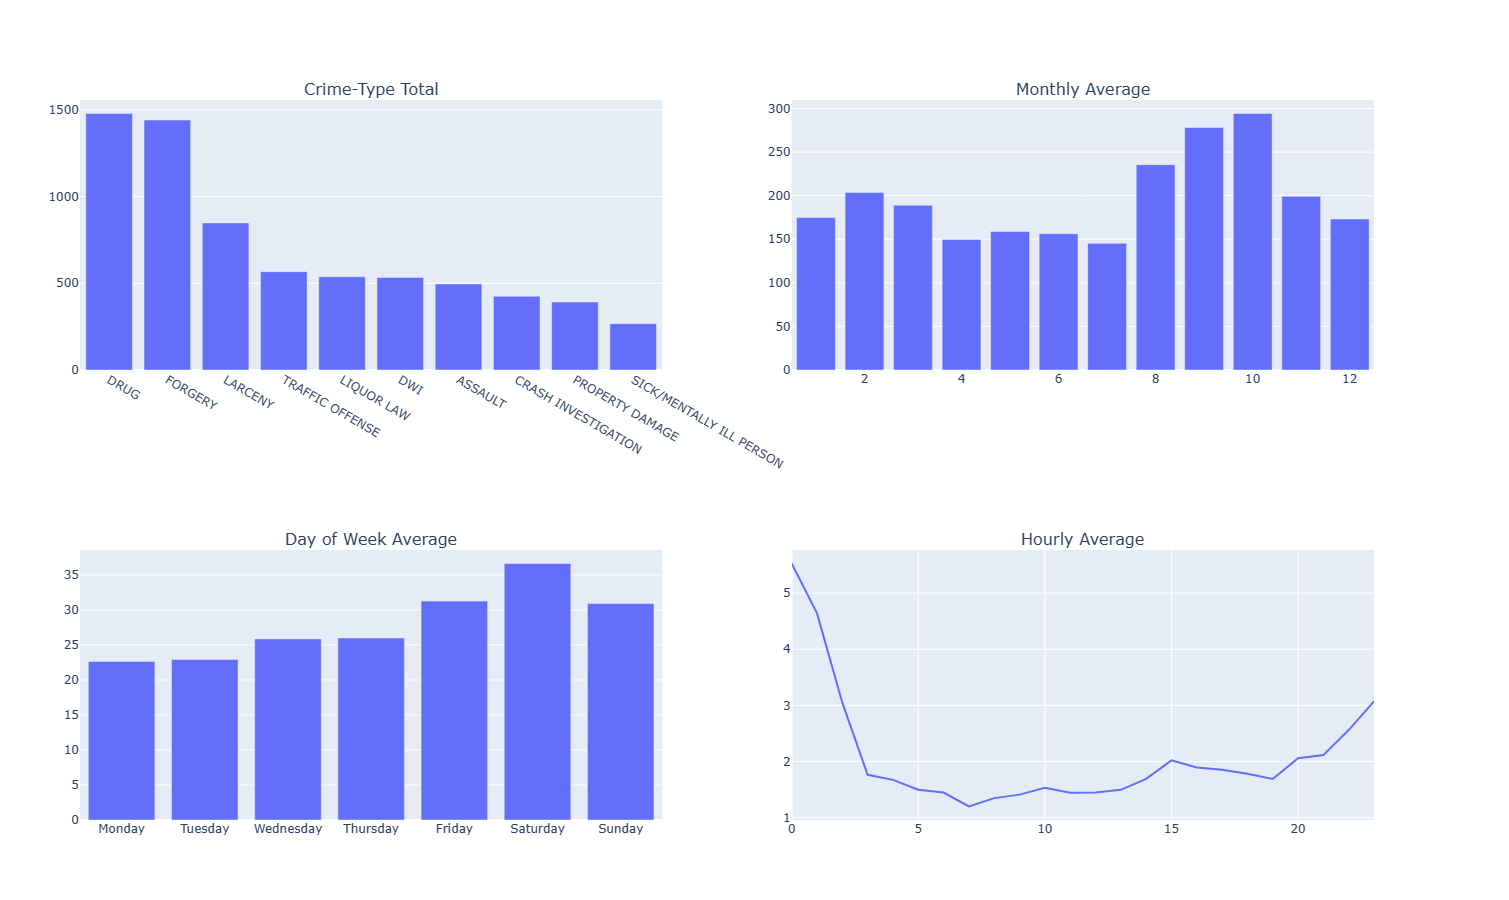

In [63]:
fig.show()

#### Random Forest Metrics

In [64]:
rf_results.astype(float).round(3)

,location,crime_type,hour
accuracy,0.428,0.456,0.432
precision,0.900,0.900,0.940
recall,0.430,0.460,0.430
f1-score,0.580,0.600,0.590


#### Tensorflow Metrics

In [67]:
tf_results.astype(float).round(3)

,location,crime_type,hour
accuracy,0.426,0.522,0.422
precision,0.488,0.530,0.443
recall,0.416,0.516,0.418
f1-score,0.449,0.523,0.430


- precision for random forest is in the 0.90+ range
- recall for both model is similar
- f1-scores for random forest ranged from 0.58 to 0.60. Tensorflow did not perform as well with ranges from 0.45 to 0.503

Certain limitations should be noted. The crime data did not include rows for timestamps where no crime occurred. An attempt was made to create a one hot encoding of combined location and crime-type, but the resulting data would have too many columns that would severely tax my current hardware. This inability to account for times when crime did not occur could significantly impact the accuracy and usefulness of the machine learning models. It is worth looking into implementing this data in order to create a more powerful and accurate model.

In [66]:
# export cleaned data for use in application
crime_df.to_csv('..\data\crime-df.csv', index=False)